# Description of this notebook

The functions defined below help pre-process the raw data of the epilepsy problem and make it suitable for CNN models defined in this project to take as input. In this notebook, we split the data in training/dev/test sets. We perform data-augmentation of 1-D data using sliding windows to create many more examples for neural networks to be trained on.

In [45]:
import numpy as np
from os import listdir, mkdir
from os.path import isfile, join
import h5py as h5
import matplotlib.pyplot as plt

Use `export_to` variable to point to the directory where the dataset after processing will be stored. Please only change the iteration number of this variable (for smooth operation) and not the prefix. Example: <br>

`export_to = 'random-iter-5/'`

In [46]:
export_to = 'random-iter-1/'

In [47]:
# If this code shows an error, the directory probably already exists
# In that case, increment the above export_to variable's value
# Example previous export_to = 'random-iter-4'. Set to 'random-iter-5'

mkdir(export_to)
print("Directory created")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'random-iter-1/'

### Reading data

The sets in the dataset are divided into five categories. Follow the link to check the description: [Bonn Dataset](http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3)


SET A:	Z directory with	Z000.txt - Z100.txt<br>
SET B: 	O directory with	O000.txt - O100.txt<br>
SET C:	N directory with	N000.txt - N100.txt<br>
SET D:	F directory	with	F000.txt - F100.txt<br>
SET E:	S directory with	S000.txt - S100.txt<br>

In [48]:
# Mapping from folder names (ZONFS) to set names (ABCDE)

mapping_set_to_dir = {
    'A': (0,'Z'),
    'B': (1,'O'),
    'C': (2,'N'),
    'D': (3,'F'),
    'E': (4,'S')
}

file_lists = []
for s,d in mapping_set_to_dir.items():
    file_lists.insert(d[0], [f for f in listdir(d[1]) if isfile(join(d[1], f))])

In [49]:
file_lists[4]

['S001.txt',
 'S002.txt',
 'S003.txt',
 'S004.txt',
 'S005.txt',
 'S006.txt',
 'S007.txt',
 'S008.txt',
 'S009.txt',
 'S010.txt',
 'S011.txt',
 'S012.txt',
 'S013.txt',
 'S014.txt',
 'S015.txt',
 'S016.txt',
 'S017.txt',
 'S018.txt',
 'S019.txt',
 'S020.txt',
 'S021.txt',
 'S022.txt',
 'S023.txt',
 'S024.txt',
 'S025.txt',
 'S026.txt',
 'S027.txt',
 'S028.txt',
 'S029.txt',
 'S030.txt',
 'S031.txt',
 'S032.txt',
 'S033.txt',
 'S034.txt',
 'S035.txt',
 'S036.txt',
 'S037.txt',
 'S038.txt',
 'S039.txt',
 'S040.txt',
 'S041.txt',
 'S042.txt',
 'S043.txt',
 'S044.txt',
 'S045.txt',
 'S046.txt',
 'S047.txt',
 'S048.txt',
 'S049.txt',
 'S050.txt',
 'S051.txt',
 'S052.txt',
 'S053.txt',
 'S054.txt',
 'S055.txt',
 'S056.txt',
 'S057.txt',
 'S058.txt',
 'S059.txt',
 'S060.txt',
 'S061.txt',
 'S062.txt',
 'S063.txt',
 'S064.txt',
 'S065.txt',
 'S066.txt',
 'S067.txt',
 'S068.txt',
 'S069.txt',
 'S070.txt',
 'S071.txt',
 'S072.txt',
 'S073.txt',
 'S074.txt',
 'S075.txt',
 'S076.txt',
 'S077.txt',

In [50]:
# Read every file from each data folder and store in the dictionary raw_dataset
# Please make sure there are no junk files present in the folder

raw_dataset = { }

for s,d in mapping_set_to_dir.items():
    
    for f in file_lists[d[0]]:
        curr_example = np.loadtxt(join(d[1], f))
        

        if (s in raw_dataset):
            raw_dataset[s] = np.append(raw_dataset[s], [curr_example], axis=0)
        else:
            raw_dataset[s] = np.array([curr_example])

In [51]:
raw_dataset['E'].shape

(100, 4097)

## Visualizing data

Each training example in raw_dataset contains an EEG signal of 4097 data points.<br>
The values represent the values of voltage levels observed by the electrodes.<br>

Let's plot a random example and visualize the data that is given to us.

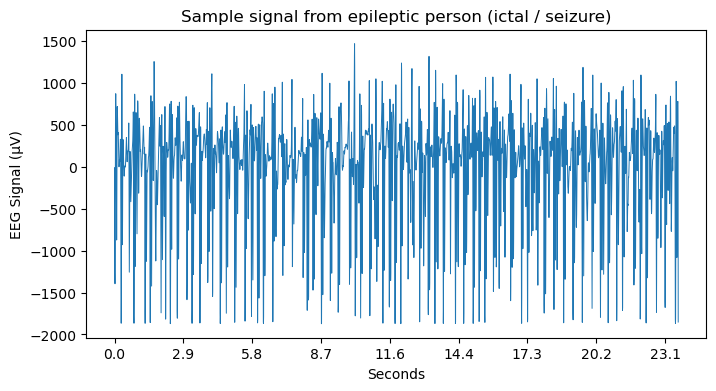

In [52]:
s = 'E'
index = 46

plot_title = ''
if (s in ['A', 'B']):
    plot_title = 'Sample signal from non-epileptic person'
elif (s in ['C', 'D']):
    plot_title = 'Sample signal from epileptic person (non-ictal / non-seizure)'
elif (s == 'E'):
    plot_title = 'Sample signal from epileptic person (ictal / seizure)'
else:
    print('s can be one of A,B,C,D,E')

plt.figure(figsize=(8,4))
plt.plot(raw_dataset[s][index], linewidth=0.7)
plt.title(plot_title)
plt.xlabel('Seconds')
plt.ylabel('EEG Signal (\u00B5V)')
tick_points = np.arange(0,9)*500 # each signal contains 4097 data points
plt.xticks(tick_points, np.round((tick_points/173.16)*10)/10) # mapping n-th data point to the time in seconds from the start of signal (173.16 Hz)
plt.show()

## Data augmentation

Since neural networks are hungry for data to perform adequately, and the available data has only 500 examples of data (100 per set). A good solution to this problem would be to split the data into smaller signals. In this manner, we'll have lots of examples, albeit small.

The below procedure uses sliding window with specified `window_size` and `stride` and returns a new dataset.

In [53]:
def create_augmented_dataset(raw_dataset, window_size = 512, stride = 64, verbose=False):
    """
    This function augments the dataset using sliding windows
    
    Parameters:
    raw_dataset: Dictionary containing a batch of examples for one set in each key
    window_size: Sliding window size
    stride: Steps by which sliding window moves and samples
    verbose: Display progress
    
    Returns:
    augmented_dataset: Dictionary containing a batch of smaller augmented examples than raw_dataset
    
    
    """
    
    augmented_dataset = { }

    for s,Xset_raw in raw_dataset.items():
        
        if (verbose):
            print('Processing set ' + s)

        total_points = Xset_raw.shape[1]

        # no. of examples generated from single training example using sliding window
        # = floor((total_points - window_size) / stride) + 1
        iterations = ((total_points - window_size) // stride) + 1

        for x_raw in Xset_raw:

            for i in range(iterations):
                window_slice_from = i*stride
                window_slice_to = i*stride + window_size

                if (s in augmented_dataset):
                    augmented_dataset[s] = np.append(augmented_dataset[s], [x_raw[window_slice_from:window_slice_to]], axis=0)
                else:
                    augmented_dataset[s] = np.array([x_raw[window_slice_from:window_slice_to]])

    
    if (verbose):
        print('Done.')
    return augmented_dataset


# Splitting of the data

After randomly shuffling of the dataset, we take three sets, train (90%), dev (5%), and test (5%).

In [54]:
raw_dataset_train = { }
raw_dataset_dev = { }
raw_dataset_test = { }

for s,Xset_raw in raw_dataset.items():
    
    # randomly shuffle the data, just to make sure
    # that all train/dev/test sets come from same
    # distribution, (possibly not from a same person)
    np.random.shuffle(raw_dataset[s])
    
    ninety_percent = np.floor(0.9 * raw_dataset[s].shape[0]).astype(int)
    five_percent = np.floor(0.05 * raw_dataset[s].shape[0]).astype(int)
    
    # train set 0 - 89 (90%)
    raw_dataset_train[s] = raw_dataset[s][0:ninety_percent,:]
    
    # dev set 90 - 94 (5%)
    raw_dataset_dev[s] = raw_dataset[s][ninety_percent:ninety_percent+five_percent,:]
    
    # test set 95 - 99 (5%)
    raw_dataset_test[s] = raw_dataset[s][ninety_percent+five_percent:,:]

In [55]:
print(raw_dataset_train['D'].shape)
print(raw_dataset_dev['A'].shape)
print(raw_dataset_test['C'].shape)

(90, 4097)
(5, 4097)
(5, 4097)


#### Scheme - 1

Let's try splitting the data with the window size of 512 and stride of 64. As done in the Scheme-1 of the paper "An automated system for epilepsy detection using EEG brain signals based on deep learning approach" by Ihsan Ullah et. al. This method creates 28,500 examples from 500 examples which amounts to 5700 per set (5130 for training).

In [56]:
print("Augmenting training data")
aug_dataset512_train = create_augmented_dataset(raw_dataset_train, window_size=512, stride=64, verbose=True)

print("Augmenting dev data")
aug_dataset512_dev = create_augmented_dataset(raw_dataset_dev, window_size=512, stride=256, verbose=True)

print("Augmenting test data")
aug_dataset512_test = create_augmented_dataset(raw_dataset_test, window_size=512, stride=256, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


#### Scheme - 2

Also, try the window size of 1024 with the stride of 128. Creates 12,500 examples which amount to 2500 per set (11250 for training).

In [57]:
print('Augmenting training data')
aug_dataset1024_train = create_augmented_dataset(raw_dataset_train, window_size=1024, stride=128, verbose=True)

print ('Augmenting dev data')
aug_dataset1024_dev = create_augmented_dataset(raw_dataset_dev, window_size=1024, stride=512, verbose=True)

print('Augmenting test data')
aug_dataset1024_test = create_augmented_dataset(raw_dataset_test, window_size=1024, stride=512, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


In [58]:
print(aug_dataset512_train['E'].shape)
print(aug_dataset512_dev['C'].shape)
print(aug_dataset512_test['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [59]:
print(aug_dataset1024_train['E'].shape)
print(aug_dataset1024_dev['C'].shape)
print(aug_dataset1024_test['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


## Saving the data

Calling the `create_augmented_dataset` for the above parameters takes few minutes each time. To speed up learning these augmented datasets are saved to the disk so that they can be loaded next time feasibly. We use a popular library called `h5py` for this purpose.

<blockquote><b>Note:</b> The test set is augmented twice (once down below in this notebook). One for measuring accuracy and another for measuring accuracy with voting (as described in the literature of this project).</blockquote>

In [60]:
with h5.File(export_to + 'aug_dataset512.h5', 'w') as aug_file512:
    
    train512 = aug_file512.create_group('train')
    dev512 = aug_file512.create_group('dev')
    test512 = aug_file512.create_group('test')

    for s in aug_dataset512_train.keys():
        
        train512.create_dataset(s, data=aug_dataset512_train[s])
        dev512.create_dataset(s, data=aug_dataset512_dev[s])
        test512.create_dataset(s, data=aug_dataset512_test[s])
        

In [61]:
with h5.File(export_to + 'aug_dataset1024.h5', 'w') as aug_file1024:
    
    train1024 = aug_file1024.create_group('train')
    dev1024 = aug_file1024.create_group('dev')
    test1024 = aug_file1024.create_group('test')

    for s in aug_dataset1024_train.keys():
        
        train1024.create_dataset(s, data=aug_dataset1024_train[s])
        dev1024.create_dataset(s, data=aug_dataset1024_dev[s])
        test1024.create_dataset(s, data=aug_dataset1024_test[s])

In [62]:
aug_file512 = h5.File(export_to + 'aug_dataset512.h5', 'r')
print(aug_file512['train']['A'].shape)
print(aug_file512['dev']['C'].shape)
print(aug_file512['test']['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [63]:
aug_file1024 = h5.File(export_to + 'aug_dataset1024.h5', 'r')
print(aug_file1024['train']['A'].shape)
print(aug_file1024['dev']['C'].shape)
print(aug_file1024['test']['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


## Visualizing augmented examples

Change the class label `s` = {A, B, C, D, E} and `index` to plot different examples in the augmented dataset.

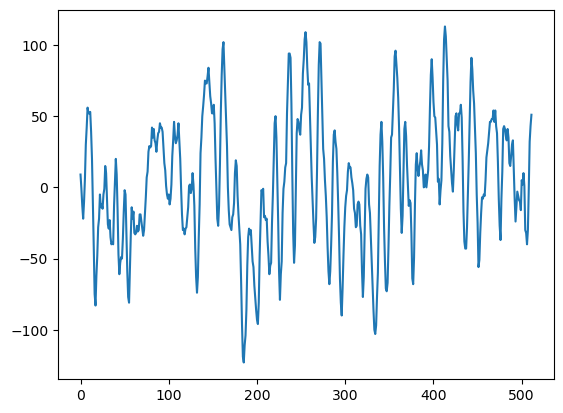

In [64]:
s = 'B'
index = 400
plt.plot(aug_file512['train'][s][index])

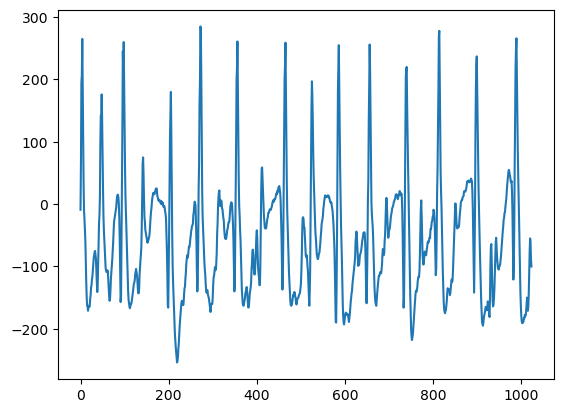

In [65]:
s = 'E'
index = 175
plt.plot(aug_file1024['train'][s][index])

In [66]:
aug_file512.close()

In [67]:
aug_file1024.close()

## One-hot labels

Let's convert the dataset which is in dictionary format, to a single giant training set which contains all classes and a label set represented in one-hot format.

Tensorflow provides built in support for converting the a vector into one hot matrix.

In [68]:
import tensorflow as tf

In [72]:
# Define the class map for 3 classes
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def read_dataset_and_one_hot_labels(filepath, setname, verbose=False):
    """
    Converts the dataset's labels into one-hot encoding
    
    Parameters:
    filepath: augmented dataset without one-hot encoding
    setname: either 'train', 'dev', or 'test'
    verbose: Display progress
    
    Returns:
    data: dataset with keys X_<setname>, Y_<setname>_classname, and Y_<setname> (one-hot labels). 
    """
    
    data = {}

    # Read dataset that is already stored in the file
    with h5.File(filepath, 'r') as aug_file:

        # 3-class classification problem
        no_of_classes = 3

        for s in aug_file[setname].keys():
            if verbose:
                print(f"Processing class: {s}")

            class_length = len(aug_file[setname][s])

            # Iterate through each example in the class
            for i in range(class_length):
                if verbose and i % (class_length // 5) == 0:
                    print(f"{(i / class_length * 100):.0f}%")

                # Append data and labels
                if ('X_' + setname) in data:
                    data['X_' + setname] = np.append(data['X_' + setname], [aug_file[setname][s][i]], axis=0)
                    data['Y_' + setname + '_classname'] = np.append(data['Y_' + setname + '_classname'], [class_map[s]], axis=0)
                else:
                    data['X_' + setname] = np.array([aug_file[setname][s][i]])
                    data['Y_' + setname + '_classname'] = np.array([class_map[s]])

        if verbose:
            print("Converting to one_hot")
        
        # Convert class labels to one-hot encoding
        data['Y_' + setname] = tf.one_hot(data['Y_' + setname + '_classname'], depth=no_of_classes, axis=-1)

        if verbose:
            print("Done.")

    return data


In [73]:
print("Converting training set to one hot")
data512_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data512_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data512_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'test', verbose=True)

Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [74]:
with h5.File(export_to + 'datafile512.h5', 'w') as datafile512:

    datafile512.create_dataset('X_train', data=data512_train['X_train'])
    datafile512.create_dataset('Y_train_classname', data=data512_train['Y_train_classname'])
    datafile512.create_dataset('Y_train', data=data512_train['Y_train'])
    
    datafile512.create_dataset('X_dev', data=data512_dev['X_dev'])
    datafile512.create_dataset('Y_dev_classname', data=data512_dev['Y_dev_classname'])
    datafile512.create_dataset('Y_dev', data=data512_dev['Y_dev'])
    
    datafile512.create_dataset('X_test', data=data512_test['X_test'])
    datafile512.create_dataset('Y_test_classname', data=data512_test['Y_test_classname'])
    datafile512.create_dataset('Y_test', data=data512_test['Y_test'])

In [75]:
print("Converting training set to one hot")
data1024_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data1024_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data1024_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'test', verbose=True)

Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [76]:
with h5.File(export_to + 'datafile1024.h5', 'w') as datafile1024:

    datafile1024.create_dataset('X_train', data=data1024_train['X_train'])
    datafile1024.create_dataset('Y_train_classname', data=data1024_train['Y_train_classname'])
    datafile1024.create_dataset('Y_train', data=data1024_train['Y_train'])
    
    datafile1024.create_dataset('X_dev', data=data1024_dev['X_dev'])
    datafile1024.create_dataset('Y_dev_classname', data=data1024_dev['Y_dev_classname'])
    datafile1024.create_dataset('Y_dev', data=data1024_dev['Y_dev'])
    
    datafile1024.create_dataset('X_test', data=data1024_test['X_test'])
    datafile1024.create_dataset('Y_test_classname', data=data1024_test['Y_test_classname'])
    datafile1024.create_dataset('Y_test', data=data1024_test['Y_test'])

# Test set for voting accuracy

We'll augment the test set second time. This time we'll store the dataset a bit differently from previous methods. We'll have multiple input data for each example with the same label. During test time, we'll feed all those inputs to the neural network, which will predict the output classes for each of the inputs. Then the class name in majority is chosen as the output.

In [77]:
def augment_test_example(ex, window_size=512, stride=64):
    """
    Augments one dataset example with sliding window approach
    
    Used with test dataset to create multiple (typically 3) slices from one example
    The majority of the predictions on those 3 slices will be considered
    
    Parameters:
    ex: one example from dataset
    window_size: sliding window size
    stride: sliding window stride
    
    Returns:
    aug_ex: numpy array containing multiple smaller (augmented) examples
    """
    
    total_points = ex.shape[0]
    aug_ex = None
    
    # no. of examples generated from single training example using sliding window
    # = floor((total_points - window_size) / stride) + 1
    iterations = ((total_points - window_size) // stride) + 1

    for i in range(iterations):
        
        # window slice
        window_slice_from = i*stride
        window_slice_to = i*stride + window_size

        try:
            aug_ex = np.append(aug_ex, [ex[window_slice_from:window_slice_to]], axis=0)
        except:
            aug_ex = np.array([ex[window_slice_from:window_slice_to]])
    
    return aug_ex


In [78]:
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def create_test_set_for_voting(testset, window_size=512, stride=64, divisions=2):
    """
    Augments whole test set in a way where each example contains multiple smaller slices
    
    The augmented dataset created by this function will be used by accuracy for voting measure
    Each example is divided into several divisions
    Each division consists of multiple slices (smaller examples)
    
    Parameters:
    testset: dictionary containing test examples for each class
    window_size: sliding window size
    stride: sliding window stride
    divisions: number of different examples to create from one example
    
    Returns:
    (new_test_set_X, new_test_set_Y, new_test_set_Y_onehot): numpy array of slices, labels, one-hot labels
    """
    
    new_test_set_X = None
    new_test_set_Y = []
    new_test_set_Y_onehot = None
    
    no_of_classes = 3
    identity = np.eye(no_of_classes)
    
    # loop over classes
    for c,class_data in testset.items():
        
        # loop over training examples
        for ex in class_data:
            
            for d in range(divisions):
                
                division_size = ex.shape[0] // divisions
            
                aug_ex = augment_test_example(ex[d*division_size:(d+1)*division_size], window_size=window_size, stride=stride)
                one_hot = identity[class_map[c]]

                try:
                    new_test_set_X = np.append(new_test_set_X, [aug_ex], axis=0)
                    new_test_set_Y_onehot = np.append(new_test_set_Y_onehot, [one_hot], axis=0)
                except:
                    new_test_set_X = np.array([aug_ex])
                    new_test_set_Y_onehot = np.array([one_hot])
                new_test_set_Y = np.append(new_test_set_Y, class_map[c])
        
    return new_test_set_X, new_test_set_Y, new_test_set_Y_onehot

In [79]:
test_X_v_512, test_Y_v_512, test_Y_oh_v_512 = create_test_set_for_voting(raw_dataset_test, window_size=512, stride=256, divisions=4)


In [80]:
test_X_v_1024, test_Y_v_1024, test_Y_oh_v_1024 = create_test_set_for_voting(raw_dataset_test, window_size=1024, stride=512, divisions=2)

The shape of the augmented test set for accuracy with voting is such that the dimensions represent:

For X<br>
1 - No. of test examples<br>
2 - No. of slices for each example<br>
3 - No. of features<br>
<br>
For Y_onehot<br>
1 - No. of test examples<br>
2 - No. of classes<br>

In [81]:
print(test_X_v_512.shape)
print(test_X_v_1024.shape)

(100, 3, 512)
(50, 3, 1024)


Save the augmented test set (for voting) in a new file

In [82]:
with h5.File(export_to + 'testset_voting_512.h5', 'w') as testset_voting_512:
    
    testset_voting_512.create_dataset('X', data=test_X_v_512)
    testset_voting_512.create_dataset('Y', data=test_Y_v_512)
    testset_voting_512.create_dataset('Y_onehot', data=test_Y_oh_v_512)

In [83]:
with h5.File(export_to + 'testset_voting_1024.h5', 'w') as testset_voting_1024:
    
    testset_voting_1024.create_dataset('X', data=test_X_v_1024)
    testset_voting_1024.create_dataset('Y', data=test_Y_v_1024)
    testset_voting_1024.create_dataset('Y_onehot', data=test_Y_oh_v_1024)